In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx

In [3]:
base_dir = '/home/fiona/birdMigration/results/radar'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
boundary = voronoi.query('boundary == True').radar.values

In [4]:
def load_results(models, experiments, base_dir):
    results = dict()
    bird_scales = dict()
    fluxes = dict()
    att = dict()
    for i, m in enumerate(models):

        experiment = experiments[i]

        # load predictions
        model_dir = osp.join(base_dir, 'testing', m, experiment)
        files = glob.glob(model_dir + "/**/results.csv", recursive = True)
        results[m] = pd.read_csv(files[0])

        # load bird scales
        fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
        with open(fp) as f:
            cfg = load(f, Loader=Loader)
        bird_scales[m] = cfg['datasource']['bird_scale']
        
        if m == 'BirdFluxGraphLSTM':
            files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[r] = pickle.load(f)
        if m == 'AttentionGraphLSTM':
            files = glob.glob(model_dir + "/**/attention_weights_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    att[r] = pickle.load(f)
    return results, bird_scales, fluxes, att

In [5]:
def plot_fluxes(voronoi, G, fluxes, results, trial=0):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f for f in fluxes[0].values()], dim=-1)
    mask = np.concatenate([results['BirdFluxGraphLSTM'].query(f'seqID == {i}').groupby('horizon').night.all().values 
                           for i in range(len(fluxes[trial]))])


    radars = results['BirdFluxGraphLSTM'].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            if f[i,j].mean() != 0:
                val = f[j,i,mask].mean().detach().numpy()
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                if val > 0 and not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
    cmap = cm.get_cmap('YlOrBr')
    edge_widths = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths /= 0.25 * edge_widths.max()
    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    fig, ax = plt.subplots(figsize=(10,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, options={'arrowsize': edge_widths*100})
    ax.set(title='averaged inferred fluxes between radars');
    
def plot_attention(voronoi, G, att, results, trial=0):

    G_att = nx.DiGraph()
    G_att.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f for f in att[0].values()], dim=-1)
    mask = np.concatenate([results['AttentionGraphLSTM'].query(f'seqID == {i+1}').groupby('horizon').night.all().values 
                           for i in range(len(att[trial]))])


    radars = results['AttentionGraphLSTM'].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            if f[i,j].mean() != 0:
                val = f[j,i,mask].mean().detach().numpy()
                G_att.add_edge(j, i, att=val)
    
    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_att, 'radar').items()}
    cmap = cm.get_cmap('YlOrBr')
    att_weights = np.array(list(nx.get_edge_attributes(G_att,'att').values()))
    edge_widths = att_weights / (0.2 * att_weights.max())
    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_att.nodes(data=True)]
    edge_colors = cmap(att_weights)
    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_att, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    sm = plt.cm.ScalarMappable(cmap=cmap)
    #sm._A = []
    plt.colorbar(sm, label='attention weight');

## Previous results
### All radars

In [5]:
models = ['HA', 'GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime_km2',
               'best_settings_evaluate_daytime_km2',
                'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime',
              'best_settings_evaluate_daytime']
results_previous, bird_scales_previous, _, _ = load_results(models, experiments, base_dir)

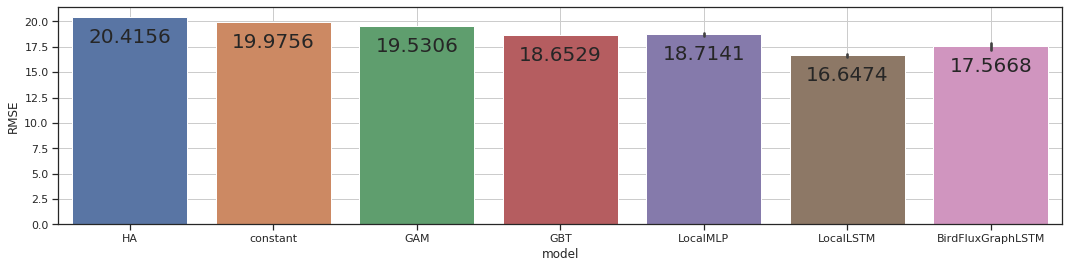

In [6]:
fig = utils.plot_average_errors(results_previous, night_only=True)

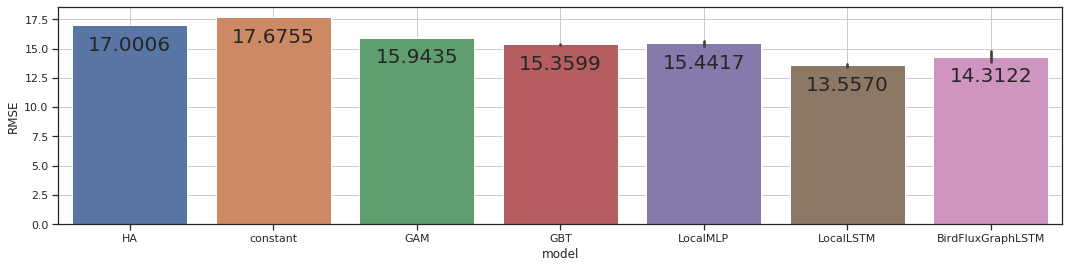

In [8]:
fig = utils.plot_average_errors(results_previous, boundary=['bezav'], night_only=True)

### Fixed boundary radars

In [11]:
models = ['HA', 'GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime_km2',
               'best_settings_evaluate_daytime_km2',
                'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime',
              'best_settings_evaluate_daytime_fixed_boundary']
results_previous_fixed_boundary, bird_scales_previous_fixed_boundary, _, _ = load_results(models, experiments, base_dir)

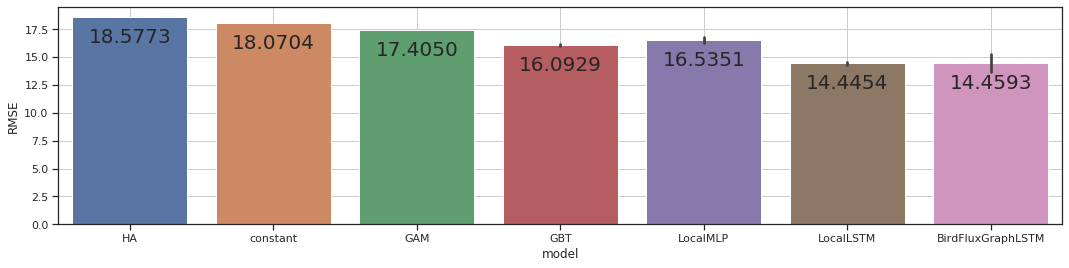

In [15]:
fig = utils.plot_average_errors(results_previous_fixed_boundary, boundary=boundary, night_only=True)

### Dummy radars

In [59]:
models = ['HA', 'GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime_km2',
               'best_settings_evaluate_daytime_km2',
                'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime',
              'best_settings_evaluate_daytime_dummy_radars']
results_previous_dummy, bird_scales_previous_dummy, _, _ = load_results(models, experiments, base_dir)

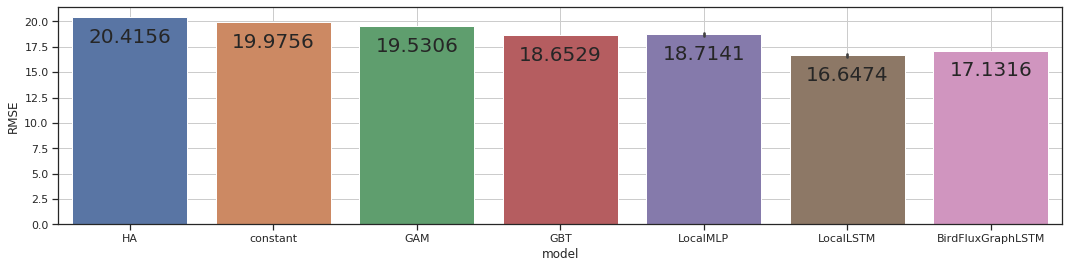

In [60]:
fig = utils.plot_average_errors(results_previous_dummy, night_only=True)

## New results 1

- Use environmental conditions from previous timestep in "edge NN" and
- enforce $flux(i\rightarrow j) = -flux(j\rightarrow i)$

### Fixed boundary radars

In [6]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'best_settings_evaluate_daytime_fixed_boundary_env_previous_enforce_conservation']
results_env_prev_fixed_boundary, _, fluxes_env_prev_fixed_boundary, _ = load_results(models, experiments, base_dir)

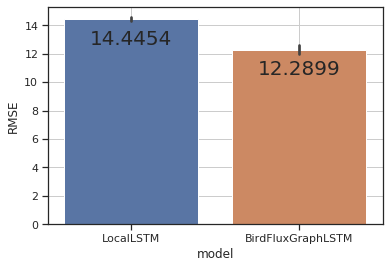

In [17]:
fig = utils.plot_average_errors(results_env_prev_fixed_boundary, boundary=boundary, night_only=True)

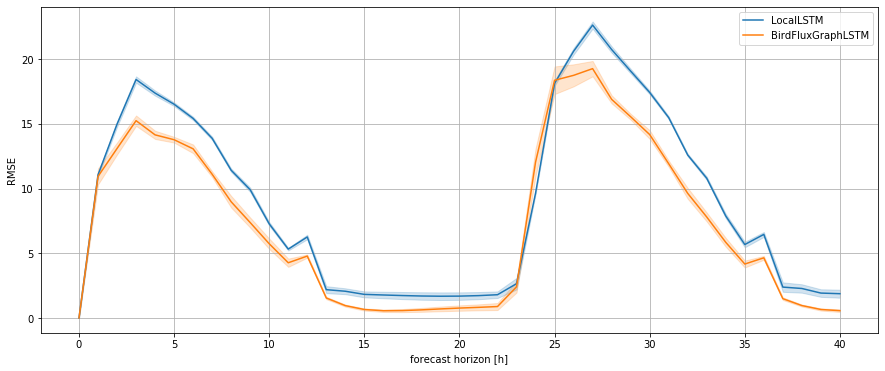

In [7]:
fig = utils.plot_errors(results_env_prev_fixed_boundary, boundary=boundary)

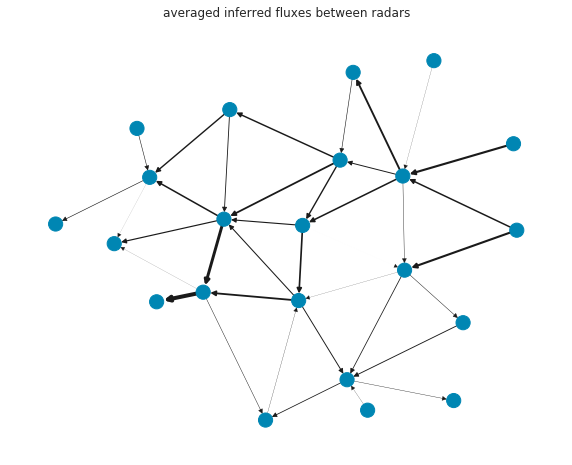

In [16]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

plot_fluxes(voronoi, G, fluxes_env_prev_fixed_boundary, results_env_prev_fixed_boundary, trial=0)

### All radars

In [9]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'best_settings_evaluate_daytime_env_previous_enforce_conservation']
results_env_prev, bird_scales_env_prev, _, _ = load_results(models, experiments, base_dir)

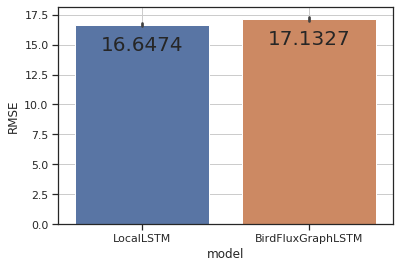

In [19]:
fig = utils.plot_average_errors(results_env_prev, night_only=True)

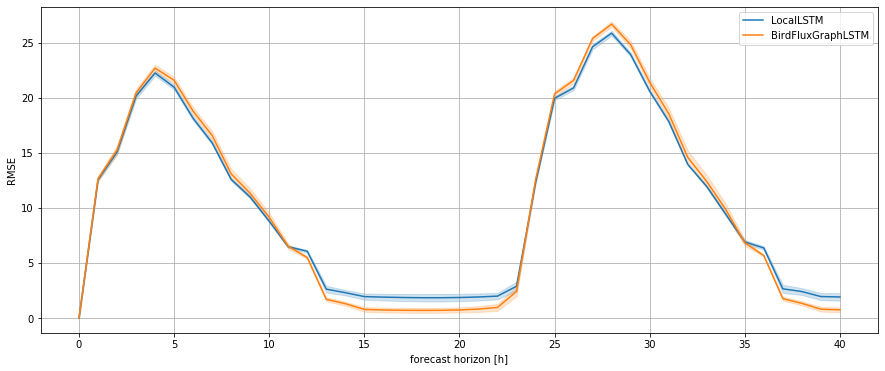

In [10]:
fig = utils.plot_errors(results_env_prev)

### Dummy radars

In [11]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'best_settings_evaluate_daytime_dummy_radars_env_previous_enforce_conservation']
results_env_prev_dummy, bird_scales_env_prev_dummy, fluxes_env_prev_dummy, _ = load_results(models, experiments, base_dir)

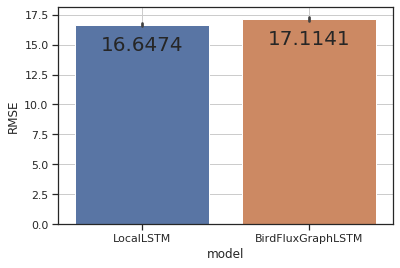

In [6]:
fig = utils.plot_average_errors(results_env_prev_dummy, night_only=True)

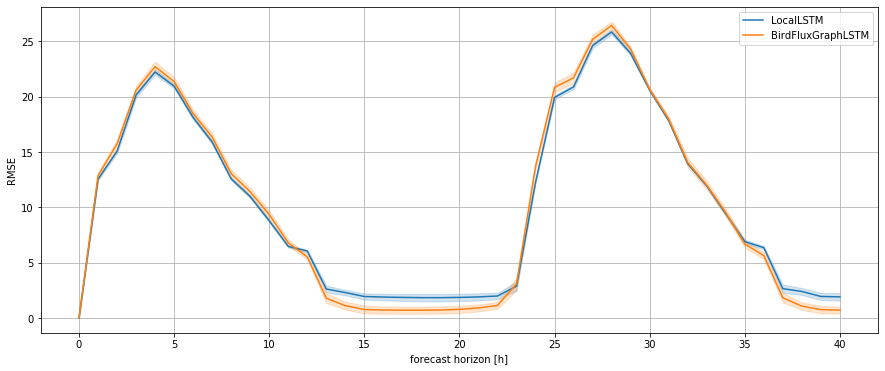

In [12]:
fig = utils.plot_errors(results_env_prev_dummy)

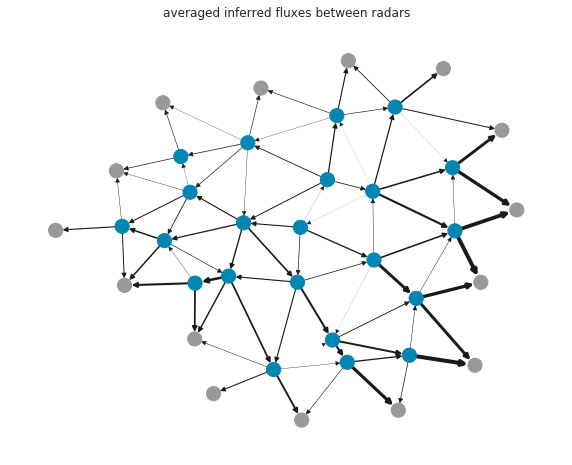

In [20]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

plot_fluxes(voronoi, G, fluxes_env_prev_dummy, results_env_prev_dummy, trial=0)

## New results 2

- same as new results 1 **plus**
- Use LSTM states as additional input to "edge NN":

$

### Fixed boundary radars

In [17]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
              'best_settings_evaluate_daytime_fixed_boundary_env_previous_enforce_conservation_hidden_states']
results_states_fixed_boundary, _, fluxes_states_fixed_boundary, _ = load_results(models, experiments, base_dir)

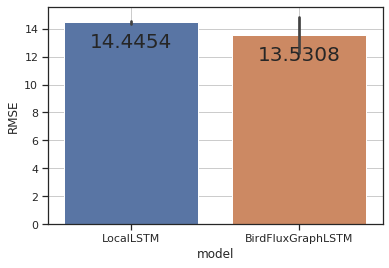

In [20]:
fig = utils.plot_average_errors(results_states_fixed_boundary, boundary=boundary, night_only=True)

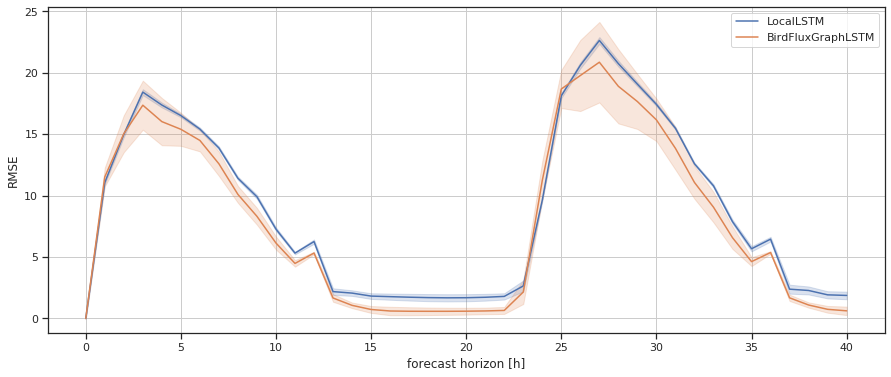

In [19]:
fig = utils.plot_errors(results_states_fixed_boundary, boundary=boundary)

## New results 3

**Attention-based spatial aggregation**
- instead of modeling fluxes along edges, extract relevant features from neighboring radars and aggregate them based on "attention weights"

In [13]:
models = ['LocalLSTM', 'AttentionGraphLSTM']
experiments = ['best_settings_evaluate_daytime',
               'best_settings_evaluate_daytime_max_dist300_without_bezav']
results_att_without_bezav, _, _, attention_without_bezav = load_results(models, experiments, base_dir)

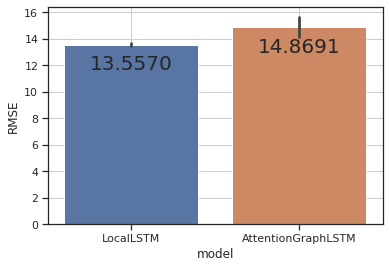

In [39]:
fig = utils.plot_average_errors(results_att_without_bezav, boundary=['bezav'], night_only=True)

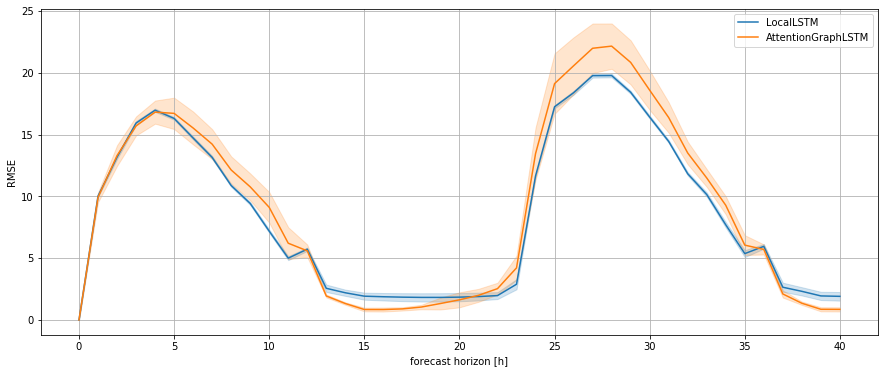

In [14]:
fig = utils.plot_errors(results_att_without_bezav, boundary=['bezav'])

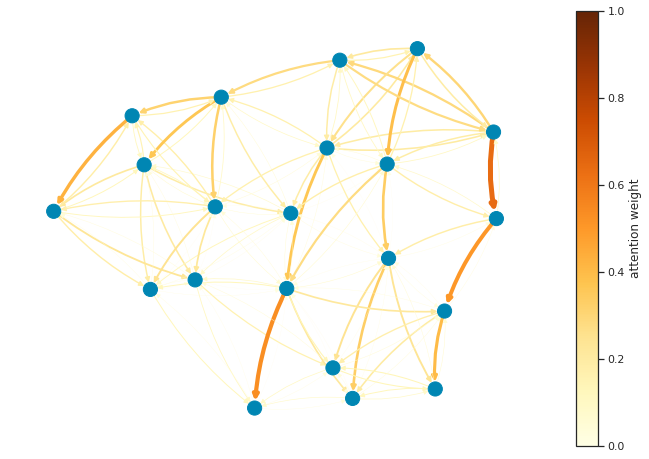

In [48]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/max_dist_dummy_radars=0_exclude=[bezav]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/max_dist_dummy_radars=0_exclude=[bezav]/radar/fall/2015/G_max_dist=300.gpickle'
G = nx.read_gpickle(G_path)

plot_attention(voronoi, G, attention_without_bezav, results_att_without_bezav, trial=0)

In [15]:
models = ['LocalLSTM', 'AttentionGraphLSTM']
experiments = ['best_settings_evaluate_daytime_km2_without_bezav_encoder_new',
               'best_settings_evaluate_daytime_max_dist300_without_bezav_encoder']
results_att_enc_without_bezav, _, _, attention_enc_without_bezav = load_results(models, experiments, base_dir)

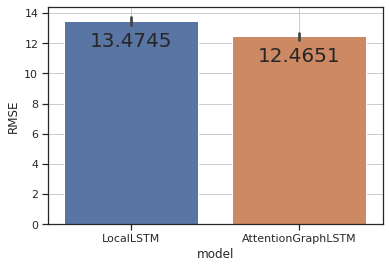

In [30]:
fig = utils.plot_average_errors(results_att_enc_without_bezav, boundary=['bezav'], night_only=True)

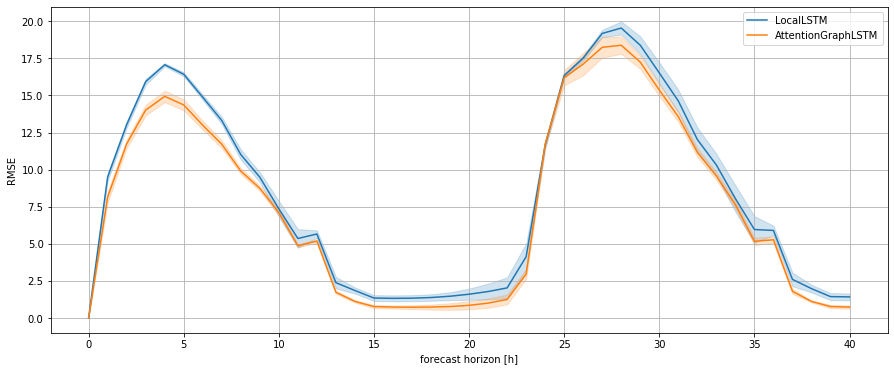

In [16]:
fig = utils.plot_errors(results_att_enc_without_bezav, boundary=['bezav'])

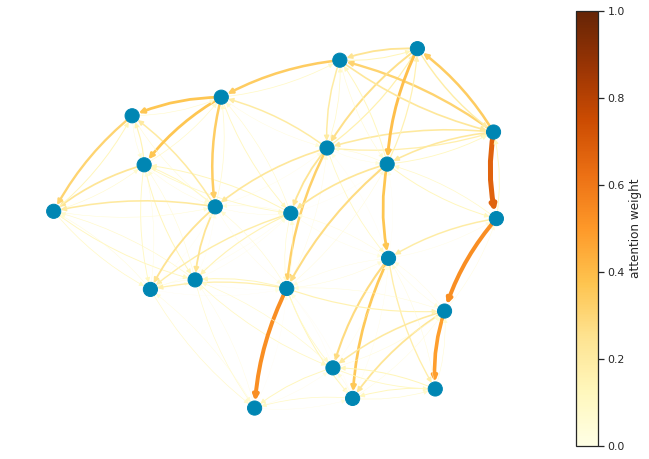

In [51]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/max_dist_dummy_radars=0_exclude=[bezav]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/max_dist_dummy_radars=0_exclude=[bezav]/radar/fall/2015/G_max_dist=300.gpickle'
G = nx.read_gpickle(G_path)

plot_attention(voronoi, G, attention_enc_without_bezav, results_att_enc_without_bezav, trial=0)

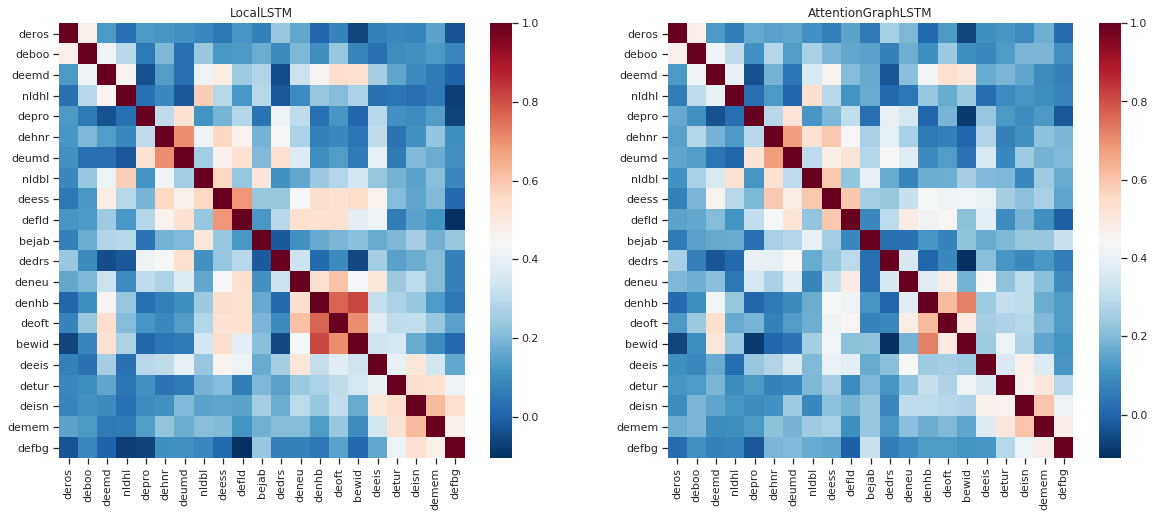

In [52]:
fig = utils.residuals_corr(results_att_enc_without_bezav, ['LocalLSTM', 'AttentionGraphLSTM'], voronoi)

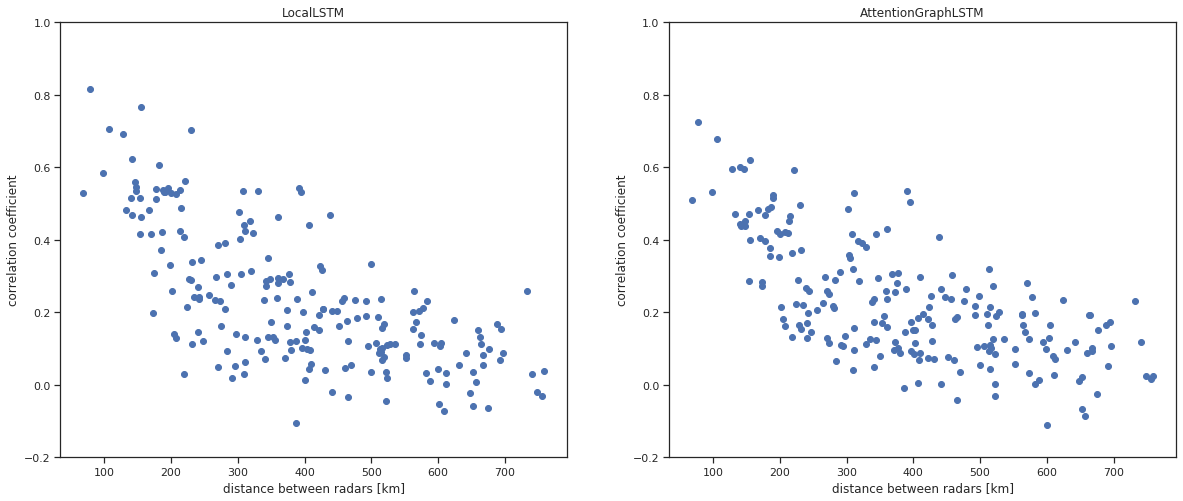

In [53]:
fig = utils.residuals_corr_vs_distance(results_att_enc_without_bezav, ['LocalLSTM', 'AttentionGraphLSTM'], voronoi)